# Урок 10. Распознавание лиц и эмоций.
## **Задание по итогам курса:**

- (упрощенное/для тех, у кого нет вебкамеры)
    1. Нужно написать приложение, которое будет получать на вход *изображение*.
    2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
    3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

- (более сложное)
    1. Нужно написать приложение, которое будет считывать и выводить кадры с *веб-камеры*.
    2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
    3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать. 
____________________
- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
- Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download gti-upm/leapgestrecog

100% 2.12G/2.13G [00:15<00:00, 111MB/s]
100% 2.13G/2.13G [00:15<00:00, 146MB/s]


In [3]:
! unzip leapgestrecog.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

Подключим все необходимые библиотеки:

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

In [5]:
DATA_ROOT = '/content/leapGestRecog'

Зададим трансформации для трейна и теста. Для Grayscale задаем число выходных слоев, равное 3, т.к. resnet не принимает одноканальные изображения

In [6]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Картинки черно-белые
                         tt.Resize([128, 128]),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor(),                       # Приведение к тензору
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])

Сохраним имена классов через загрузку одной из папок:

In [7]:
tmp_ds = ImageFolder(os.path.join(DATA_ROOT, '00'))
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Создадим тренировочный и тестовый датасеты с одними и теми же картинками, но с разным препроцессингом:

In [8]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
  train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
  test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
  train_ds_list.append(train_ds)
  test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

Общее количество картинок:

In [9]:
LEN_DS = len(train_ds)
LEN_DS

20000

Функция преобразования номера класса в его название:

In [10]:
def digit_to_classname(digit):
  for idx, itm in enumerate(CLASSES_NAME):
    if idx == digit:
      return itm

Посмотрим распределения классов в датасете:

In [17]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'01_palm': 2000, '02_l': 2000, '03_fist': 2000, '04_fist_moved': 2000, '05_thumb': 2000, '06_index': 2000, '07_ok': 2000, '08_palm_moved': 2000, '09_c': 2000, '10_down': 2000}


Распределение классов равное.

Разделим датасет на тренировачный и тестовый:

In [11]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

Проверим размерность случайного тензора в датасете:

In [12]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

Проверим дисбаланс классов:

In [16]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'05_thumb': 1608, '02_l': 1609, '01_palm': 1587, '06_index': 1606, '04_fist_moved': 1610, '03_fist': 1590, '09_c': 1610, '07_ok': 1594, '08_palm_moved': 1594, '10_down': 1592}


Дисбаланс классов есть, но он очень не существенный

Создадим даталоадеры:

In [13]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

Выведем случайное изображение в тестовом загрузчике:

torch.Size([3, 128, 128])
tensor(2) 03_fist


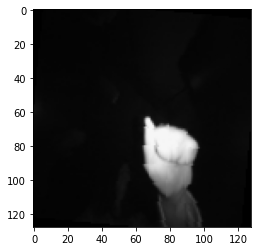

In [14]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

Функция для визуалиции батча:

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Визуализируем батч:

torch.Size([3, 128, 128])


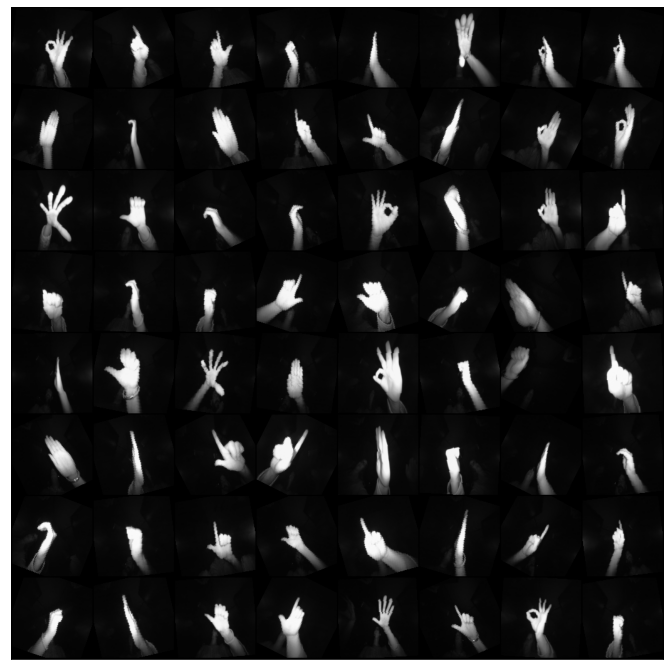

In [16]:
show_batch(train_dl)

Определим устройство для работы нейросетей:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Возьмем для классификации предобученную сеть resnet50:

In [25]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Запретим весам обучаться

In [26]:
for param in resnet.parameters():
    param.requires_grad = False

Посмотрим на слои нейросети. Нас интересует последний классификационный слой, который мы будем переобучать:

In [27]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Перезапишем последний классификационный слой, и убедимся, что остальные слои не будут обучаться:

In [28]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Создадим список обучаемых параметров и подадим его в оптимизатор. Также инициализируем функцию потерь:

In [29]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Инициализируем функцию для обучения сети:

In [30]:
from time import time
# from tqdm import tqdm

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

Обучим сеть на 5 эпохах:

In [31]:
print_every = 50
num_epoch = 5

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[5]. Batch [50]/[250]. Train loss 1.366. Train acc 60.469. Val loss 1.296. Val acc 64.500. Took 22.420 seconds
Epoch [1]/[5]. Batch [100]/[250]. Train loss 1.129. Train acc 67.797. Val loss 0.860. Val acc 76.450. Took 21.607 seconds
Epoch [1]/[5]. Batch [150]/[250]. Train loss 0.960. Train acc 72.406. Val loss 0.707. Val acc 81.175. Took 21.601 seconds
Epoch [1]/[5]. Batch [200]/[250]. Train loss 0.844. Train acc 75.781. Val loss 0.663. Val acc 81.200. Took 21.731 seconds
Epoch [1]/[5]. Batch [250]/[250]. Train loss 0.760. Train acc 78.263. Val loss 0.590. Val acc 84.075. Took 22.080 seconds
Epoch took 109.50313377380371
Epoch [2]/[5]. Batch [50]/[250]. Train loss 0.103. Train acc 79.219. Val loss 0.708. Val acc 78.550. Took 22.381 seconds
Epoch [2]/[5]. Batch [100]/[250]. Train loss 0.149. Train acc 82.922. Val loss 0.626. Val acc 81.550. Took 21.587 seconds
Epoch [2]/[5]. Batch [150]/[250]. Train loss 0.180. Train acc 84.417. Val loss 0.634. Val acc 79.525. Took 21.464 seco

Результаты неплохие, но попробуем достичь лучшего результата, обучая еще по одной эпохе нейросеть:

In [35]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=1
)

Epoch [1]/[1]. Batch [50]/[250]. Train loss 0.223. Train acc 92.531. Val loss 0.341. Val acc 89.750. Took 22.461 seconds
Epoch [1]/[1]. Batch [100]/[250]. Train loss 0.196. Train acc 93.578. Val loss 0.303. Val acc 90.900. Took 22.392 seconds
Epoch [1]/[1]. Batch [150]/[250]. Train loss 0.189. Train acc 93.698. Val loss 0.281. Val acc 92.425. Took 21.494 seconds
Epoch [1]/[1]. Batch [200]/[250]. Train loss 0.181. Train acc 93.969. Val loss 0.288. Val acc 91.600. Took 21.498 seconds
Epoch [1]/[1]. Batch [250]/[250]. Train loss 0.181. Train acc 94.025. Val loss 0.272. Val acc 92.725. Took 21.236 seconds
Epoch took 109.1430389881134


Удалось достичь 92.7% accuracy на тестовом датасете. Очень достойный результат!

Сохраним и скачаем нашу модель:

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
torch.save(resnet, '/content/drive/MyDrive/GeekBrains/PyTorch/checkpoint_92.73')

In [3]:
resnet = torch.load('/content/drive/MyDrive/GeekBrains/PyTorch/checkpoint_92.73')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Посмотрим предсказания по 5 картинкам из тестового датасета:

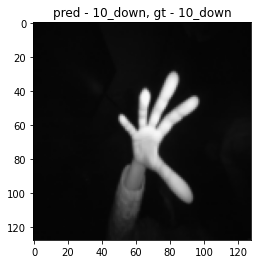

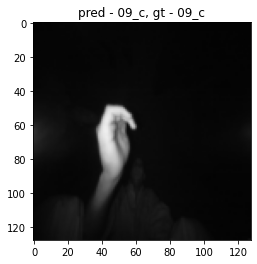

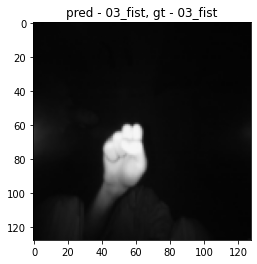

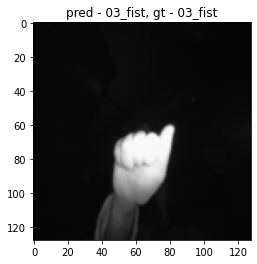

In [27]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

Ошибок в этих примерах нет.

Установим сеть для детекции лица, а также сеть от Google для детекции рук, лица и тела mediapipe (использовать будем только детектор рук)

In [4]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [5]:
! pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.2 MB/s 


Создадим класс для детекции лица и классификации жеста на фото. Логика работы метода run следующая:


*   Детектируем с помощью mtcnn лицо и сохраняем рамку и маркеры лица.
*   Детектируем руку на изображении с помощью mediapipe.


*   Вырезаем часть изображения, где есть рука, по точкам детектора рук.
*   Подаем часть изображения с рукой в обученный ранее классификатор жестов.


*   Классифицируем жест и отрисовываем рамку на лице с маркерами лица, и подписываем рамку классифицированным жестом.






In [30]:
import cv2
from PIL import Image
from facenet_pytorch import MTCNN
import mediapipe as mp

    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn, filename):
        self.classes_name = ['01_palm',
                              '02_l',
                              '03_fist',
                              '04_fist_moved',
                              '05_thumb',
                              '06_index',
                              '07_ok',
                              '08_palm_moved',
                              '09_c',
                              '10_down']
        self.preprocess = tt.Compose([
                         tt.Resize([128, 128]),
                         tt.Grayscale(num_output_channels=3), # Картинки черно-белые
                         tt.ToTensor(),                       # Приведение к тензору
                         ]) 
        self.filename = filename
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = torch.load('/content/drive/MyDrive/GeekBrains/PyTorch/checkpoint_92.73')
        self.model.eval()

    def _draw(self, frame, boxes, probs, landmarks, gests):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld, gest in zip(boxes, probs, landmarks, gests):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                    gest, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    

    def digit_to_classname(self, digit):
        for idx, itm in enumerate(self.classes_name):
          if idx == digit:
            return itm
    
    @staticmethod
    def crop_hands(frame, hand_boxes):
        hands = []
        for i, hand_box in enumerate(hand_boxes):
            pad = int((hand_box[2] - hand_box[0]) / 4)
            h,w,c = frame.shape
            pad1 = pad if hand_box[1]-pad >= 0 else hand_box[1]
            pad2 = pad if hand_box[3]+pad <= h else h - hand_box[3]
            pad3 = pad if hand_box[0]-pad >= 0 else hand_box[0]
            pad4 = pad if hand_box[2]-pad <= w else w - hand_box[2]
            hands.append(frame[int(hand_box[1]-pad1):int(hand_box[3]+pad2), 
                int(hand_box[0]-pad3):int(hand_box[2]+pad4), :])
        return hands
    
    @staticmethod
    def get_hands(img):
      mpHands = mp.solutions.hands
      hands = mpHands.Hands(False)
      npDraw = mp.solutions.drawing_utils

      results = hands.process(img)
      if results.multi_hand_landmarks:
          hand_boxes = []
          for handLms in results.multi_hand_landmarks:
              h,w,c = img.shape
              x_max = 0
              y_max = 0
              x_min = w
              y_min = h
              for lm in handLms.landmark:
                  x, y = int(lm.x * w), int(lm.y * h)
                  if x > x_max:
                      x_max = x
                  if x < x_min:
                      x_min = x
                  if y > y_max:
                      y_max = y
                  if y < y_min:
                      y_min = y
              hand_box = [x_min, y_min, x_max, y_max]
          hand_boxes.append(hand_box)
      return hand_boxes
      

    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(path_to_img)
        
        
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        print(boxes)

        hand_boxes = self.get_hands(frame)
        hands = self.crop_hands(frame, hand_boxes)

        gests = []
        for hand in hands:
            hand = cv2.cvtColor(hand, cv2.COLOR_BGR2RGB)
            hand = Image.fromarray(hand)
            hand = self.preprocess(hand)
            # hand = TF.adjust_brightness(hand, 1.5)
            # hand = TF.adjust_contrast(hand, 1.5)
            hand = hand.to(device).float()
            gest = self.model(hand[None, ...])
            print(gest)
            gest = self.digit_to_classname(gest[0].argmax())
            gests.append(gest)

        # draw on frame
        self._draw(frame, boxes, probs, landmarks, gests)
    
        # Show the frame
        cv2.imwrite(self.filename, frame)
        

Функция для запуска камеры в GoogleCollab. Делает только один кадр из видеопотока. В конце этой функции Вызывается детектор лица с классификатором жестов рук.

In [32]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  
  mtcnn = MTCNN()
  fcd = FaceDetector(mtcnn, filename)
  fcd.run(filename)

  return filename

Функция обработки фотографии из видеопотока, и вывода обработанной фотографии:

In [33]:
from IPython.display import Image as Img
def detect_face_and_cls_gest():
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Img(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))